In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Load Dataset

In [2]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2. Exploratory data analysis

## 2.1 Check Missing Values

In [5]:
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)
    sns.heatmap(dataset.isnull(), cbar=False)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


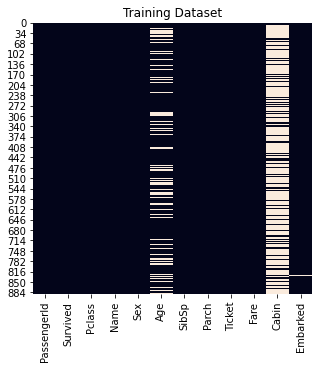

In [7]:
plot_missing_data(train_df, "Training Dataset")

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


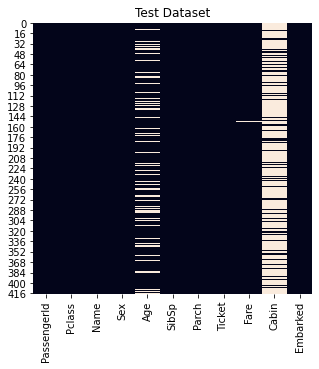

In [9]:
plot_missing_data(test_df, "Test Dataset")

Observation: 
From the plots above, both training and test data contains features with missing values in Age and Cabin 

In [10]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived, dead])
    df_survived_dead.index = ['Passengers Survived', 'Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked,figsize=(5,5))

## 2.2 Analyze Feature Survived

In [11]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [12]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

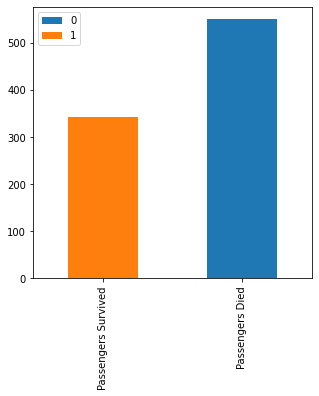

In [13]:
bar_chart_stacked(train_df, "Survived")

**Observation:**
Majority of the passengers in training data died. Only 38% survived the disaster.

## 2.3 Analyze Feature Sex

In [14]:
train_df['Sex'].value_counts().to_frame()

,Sex
male,577
female,314


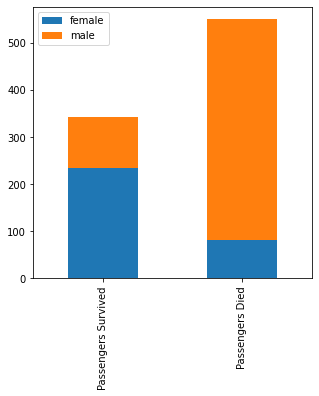

In [15]:
bar_chart_stacked(train_df, "Sex")

In [16]:
train_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

**Observation**:
Eventhough the majority of passengers were male, the majority of survivors were female

## 2.4 Analyze Feature Pclass

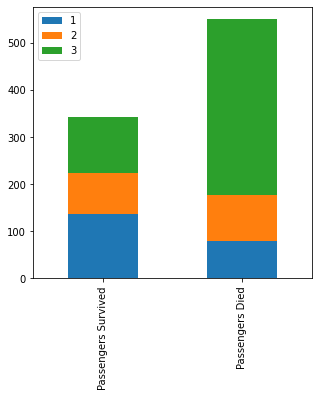

In [17]:
bar_chart_stacked(train_df, 'Pclass')

In [18]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc = 'count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [19]:
train_df.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


**Observation**:
From the plots and tables above, Pclass is an important factor to consider.
* Most passengers had class 3 tickets, yet only 24% of Class 3 passengers survived
* Almost 63% of passenger from Class 1 survived
* Approx 50% of Class 2 passenger survived

Question: Is the class or sex the deciding factor?

In [20]:
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x = feature1, y = 'Survived', hue = feature2, ci = None, data = dataset).set_ylabel('Survival rate')

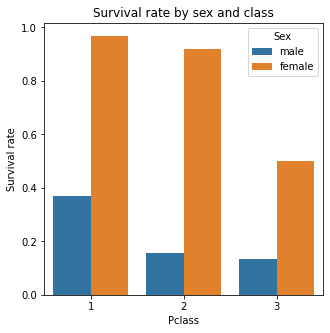

In [21]:
bar_chart_compare(train_df, "Pclass", "Sex")

In [22]:
pd.pivot_table(train_df, index = 'Survived', columns = ['Pclass', 'Sex'], values = 'Ticket', aggfunc = 'count')

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [23]:
train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

**Observation:**
Irrespective of class, the most important factor when it comes to surviving was gender. Men in class 1 had a significantly higher chance of survival when they bought cass 1 tickets. Both feature gender and class should be kept as features as both provides insightful information that would help our model. 
* Survival rate females of Class 1: 96.8%
* Survival rate females of Class 2: 92.1%
* Survival rate females of Class 3: 50%
* Survival rate males of Class 1: 36.8%

## 2.5 Analyze Feature Age

In [24]:
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

In [25]:
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] ==1],
               shade = True, ax = ax, label = 'Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 0],
               shade = True, ax=ax, label = 'Died')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


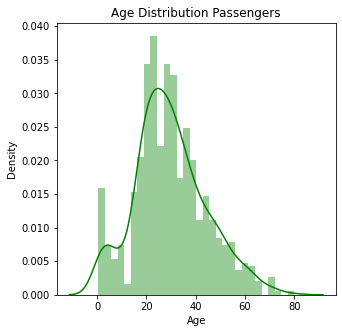

In [26]:
plot_distribution(train_df, "Age", "Age Distribution Passengers")

**Observation**:
Histogram shows a fairly normal distribution. KDE does not provide additional information except a raise in survivors at a very young age. We could however investigate age and sex together

## 2.6 Analyze Feature Age & Sex together:

In [27]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fsize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=train_df).set_title(title)


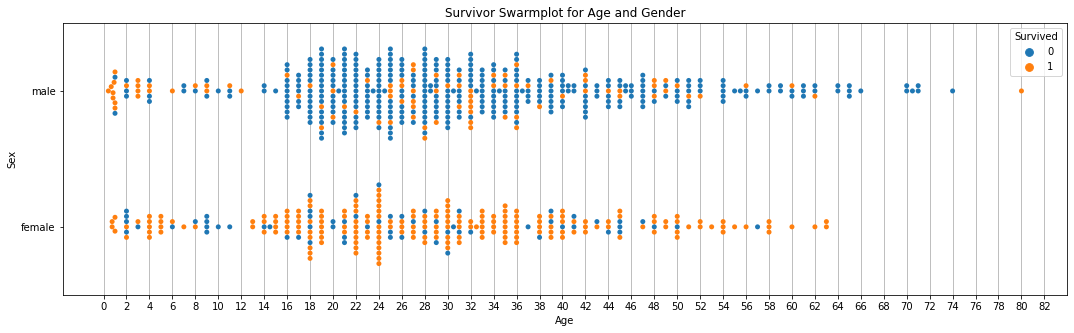

In [28]:
plot_swarm_survivors(train_df, 'Sex', 'Age', 'Survivor Swarmplot for Age and Gender')

**Observation**:
Big portion of male survivors are between 0 - 12. Oldest man who is 80 years old survived.

## 2.7 Analyze Features Age and Pclass Together

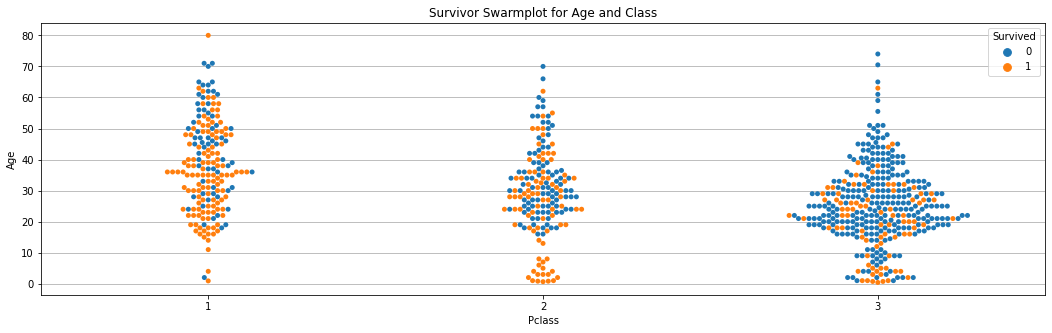

In [29]:
plot_swarm_survivors(train_df, 'Age', 'Pclass', 'Survivor Swarmplot for Age and Class')

**Observation**:Most of the survivors were in Class 1

## 2.8 Analyze Feature Fare

In [30]:
train_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


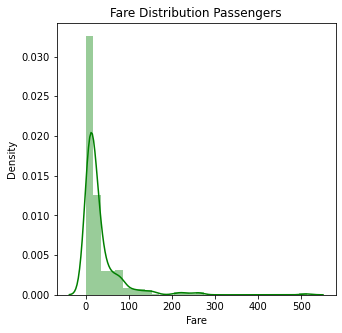

In [31]:
plot_distribution(train_df, 'Fare', 'Fare Distribution Passengers')

**Observation**:
 * Fare does not follow a normal distribution and has a huge spike at the price range 0-100. 
 * The distribution is skewed to the left with 75% of the fare paid under 31% and a max paid fare of 512$

In [32]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories)
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')

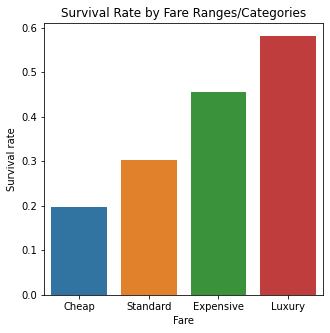

In [33]:
categories = ['Cheap','Standard','Expensive','Luxury']
plot_quartiles(train_df, 'Fare', 'Survival Rate by Fare Ranges/Categories', categories)

**Observation**:
Likelihood of survival is definitely influenced by the fare price paid

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


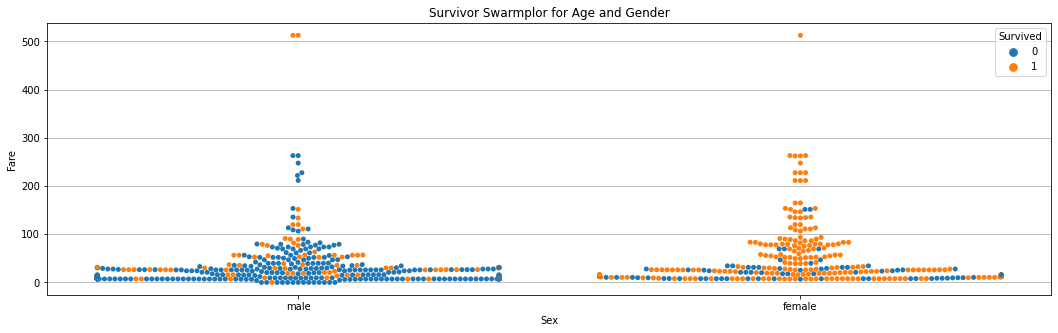

In [34]:
plot_swarm_survivors(train_df, 'Fare', 'Sex', 'Survivor Swarmplor for Age and Gender')

**Observation**:
* Irrespective of gender, all passengers with fare above [500] survived
* All male passengers that paid fare between [200-300] died

In [35]:
train_df.loc[train_df.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [36]:
len(train_df.loc[train_df.Fare==0])

15

**Observation**: 15 passengers paid no fare. We will replace the values with 0 for nan for now.

In [37]:
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN

## 2.9 Analyze Feature Embarked

In [38]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize = fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)

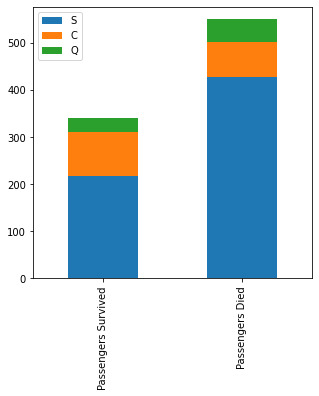

In [39]:
bar_chart_stacked(train_df, 'Embarked')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


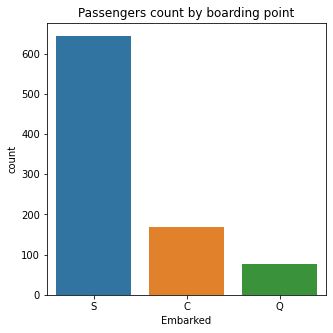

In [40]:
show_countplot(train_df, "Embarked", 'Passengers count by boarding point')

In [41]:
train_df['Embarked'].value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


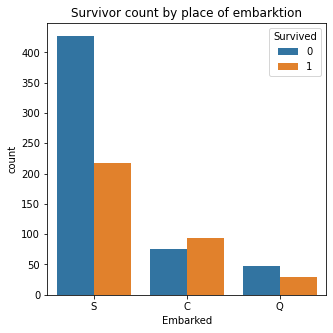

In [42]:
show_compare_countplot(train_df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [43]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc = 'count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [44]:
train_df.groupby(['Embarked']).Survived.mean().to_frame()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


**Observation:**
There are three possible values for the Embarked feature:
* Southampton, Cherbourg and Queenstown

Majority of passengers embarked from Southampton, but only 33% survived.

The highest rate of survival is for people embarked from Cherbourg with 55%. 

## 2.10 Analyze Features Embarked and Pclass Together

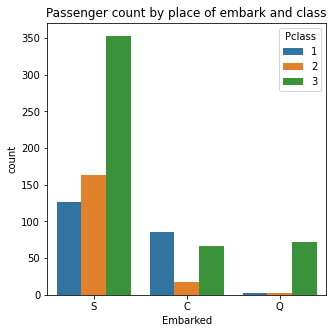

In [45]:
show_compare_countplot(train_df, "Embarked", "Pclass", "Passenger count by place of embark and class")

In [46]:
train_df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

**Observation:**
* Majority embarked at Cherbourg were class 1 passengers


# 3. Feature Engineering

In [47]:
pd.unique(train_df['Name'])

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

**Observation:**
We can create new feature by extracting the Titles from the name

In [48]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [49]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [50]:
train_df['Title'].value_counts().to_frame()

,Title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Major,2
Col,2
Mlle,2
Lady,1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


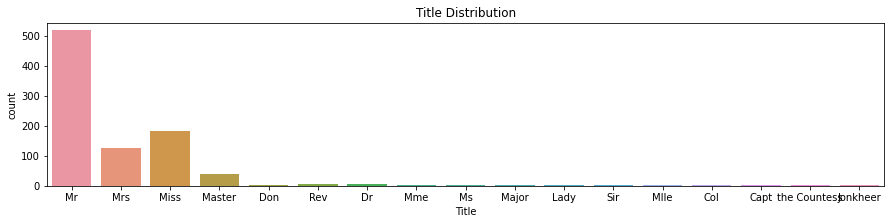

In [51]:
show_countplot(train_df, 'Title', 'Title Distribution', (15,3))

In [52]:
train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace = True)
test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace = True)
train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace = True)
test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


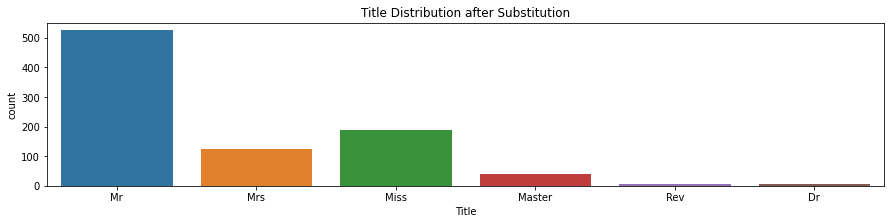

In [53]:
show_countplot(train_df, 'Title', 'Title Distribution after Substitution', (15,3))

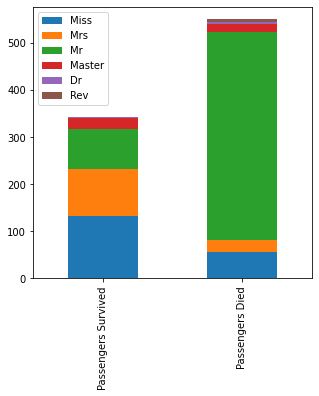

In [54]:
bar_chart_stacked(train_df, 'Title')

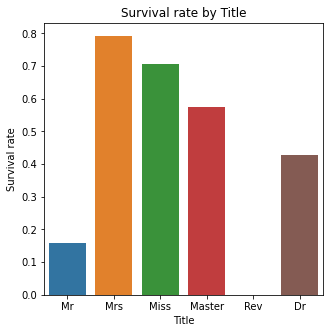

In [55]:
bar_chart_compare(train_df, "Title", title = 'Survival rate by Title')

**Observation:**
* Female titles have higher survival rate
* Master and Dr have high survival rate even though both are male titles
* All reverends died

## 3.2 Cabin and Ticket

In [56]:
train_df[['Cabin', 'Ticket']]

,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


**Observation:**
Cabins contains a lot of Nans and tickets doesn't provide any useful information

But what we can try to do:
* Extract two leading letters to create new feature
* Extract number of letter in ticket to create new feature
* Extract number of cabins used
* Extract cabin letter

In [57]:
# Extract Leading Letter:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x:x[:2])
test_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x:x[:2])

In [58]:
# Extract Ticket Length:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))

In [59]:
# Extract Number of Cabins:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))


In [60]:
# Extract Leading Letter:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))


**Investigation Results:**
Tickets

In [61]:
len(train_df['Ticket'].value_counts().to_frame())

681

In [62]:
len(train_df["Ticket_2letter"].value_counts().to_frame())

56

In [63]:
len(train_df["Ticket_len"].value_counts().to_frame())

15

In [64]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST,16,2,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3


## 3.3 Feature Family Size

In [65]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

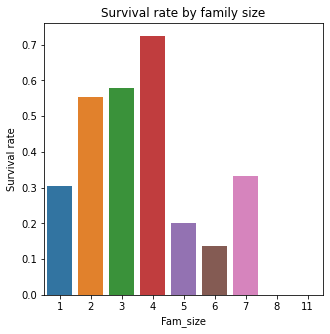

In [66]:
bar_chart_compare(train_df, "Fam_size", title = "Survival rate by family size")

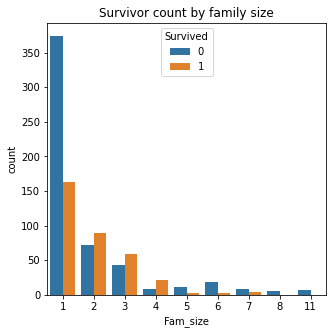

In [67]:
show_compare_countplot(train_df, "Fam_size", "Survived", "Survivor count by family size")

## 3.4 Feature Family Type
Create four groups for family size

In [68]:
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels = ['Solo', 'Small', 'Big', 'Very Big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels = ['Solo', 'Small', 'Big', 'Very Big'])

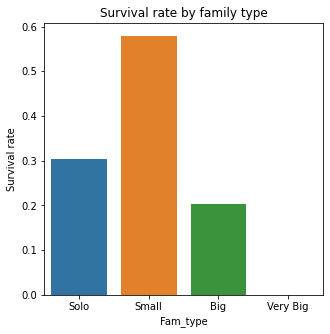

In [69]:
bar_chart_compare(train_df, "Fam_type", title = "Survival rate by family type")

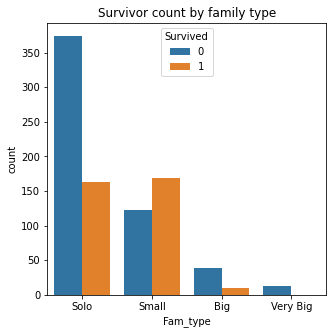

In [70]:
show_compare_countplot(train_df, "Fam_type", "Survived", "Survivor count by family type")

# 4. Trainng a Classifier
* Start by selecting the features will use and isolate the target
* Will not consider Cabin and exclude Age
* Will not be using Sex as a feature, but will use Titles that also represents the gender

In [71]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]
X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.2500,Mr,S,Small,9,A/
1,1,71.2833,Mrs,C,Small,8,PC
2,3,7.9250,Miss,S,Solo,16,ST
3,1,53.1000,Mrs,S,Small,6,11
4,3,8.0500,Mr,S,Solo,6,37


In [72]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

# Impute numerical values with median
numerical_transformer = SimpleImputer(strategy = 'median')

# Imput missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.826


In [73]:
X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.8292,Mr,Q,Solo,6,A/
1,3,7.0000,Mrs,S,Small,6,PC
2,2,9.6875,Mr,Q,Solo,6,ST
3,3,8.6625,Mr,S,Solo,6,11
4,3,12.2875,Mrs,S,Small,7,37


In [74]:
predictions = titanic_pipeline.predict(X_test)

In [75]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!
